In [1]:
# assume working in Jupyter Lab
%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.optimize import curve_fit 
from tqdm.notebook import tqdm
plt.rcParams['figure.figsize'] = (10,6)
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.4)

# import WEST libraries (needs to access CEA server)
#sys.path.append('C:/Users/JH218595/Documents/pywed')
#sys.path.append('C:/Users/JH218595/Documents/IRFMtb/')
#sys.path.append('C:/Users/JH218595/Documents/PPPAT/')
#from pppat.control_room.signals import *
#from pulse_database import PulseDB

# Importing the database

In [3]:
# Importing Resumed Parameters
data = pd.read_csv('WEST_C5_database_resumed_parameters.csv')
data

,Unnamed: 0,Ag18,Ag19,Cu,Datetime,Fe,IC_Frequencies,IC_P_Q1,IC_P_Q2,IC_P_Q4,...,Separatrix_P,day,freq_Q1,freq_Q2,freq_Q4,month,nl,pulse,time,year
0,0,1.5407,NaN,3.959761,2020,NaN,55.299999,0.0,0.0,0.0001,...,0.000000,10,55.299999,55.799999,55.799999,12,1.435414,56287,0.381975,2020
1,1,NaN,1.033671,3.550893,2020,NaN,55.299999,0.0,0.0,0.0001,...,0.000000,10,55.299999,55.799999,55.799999,12,1.545745,56287,0.484375,2020
2,2,NaN,1.235728,NaN,2020,NaN,55.299999,0.0,0.0,0.0001,...,0.000000,10,55.299999,55.799999,55.799999,12,1.573494,56287,0.586775,2020
3,3,NaN,1.143154,NaN,2020,NaN,55.299999,0.0,0.0,0.0001,...,0.000000,10,55.299999,55.799999,55.799999,12,1.567759,56287,0.689175,2020
4,4,1.0000,1.000000,2.425662,2020,NaN,55.299999,0.0,0.0,0.0001,...,0.000000,10,55.299999,55.799999,55.799999,12,1.566279,56287,0.791575,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44944,127,1.0000,NaN,742.906309,2021,NaN,55.650002,0.0,0.0,0.0000,...,NaN,14,55.650002,55.799999,55.500000,1,4.202480,56698,13.098009,2021
44945,128,1.0000,NaN,680.469794,2021,NaN,55.650002,0.0,0.0,0.0000,...,NaN,14,55.650002,55.799999,55.500000,1,4.187832,56698,13.196313,2021
44946,129,1.0000,1.982413,509.790651,2021,NaN,55.650002,0.0,0.0,0.0000,...,0.095506,14,55.650002,55.799999,55.500000,1,4.244779,56698,13.294617,2021
44947,130,1.0000,2.495325,NaN,2021,NaN,55.650002,0.0,0.0,0.0000,...,NaN,14,55.650002,55.799999,55.500000,1,3.729992,56698,13.392921,2021


# Cleaning the data

Below we remove non physical or not relevant values

In [4]:
data = data.query('nl > 2 and Ip > 0.4')\
            .query('Rext_median > 2700')

Total number of points:

In [5]:
len(data)

29913

Names of available data in the dataset:

In [6]:
data.columns

Index(['Unnamed: 0', 'Ag18', 'Ag19', 'Cu', 'Datetime', 'Fe', 'IC_Frequencies',
       'IC_P_Q1', 'IC_P_Q2', 'IC_P_Q4', 'IC_P_tot', 'IC_Positions',
       'IC_Rc_Q1_avg', 'IC_Rc_Q1_left', 'IC_Rc_Q1_right', 'IC_Rc_Q2_avg',
       'IC_Rc_Q2_left', 'IC_Rc_Q2_right', 'IC_Rc_Q4_avg', 'IC_Rc_Q4_left',
       'IC_Rc_Q4_right', 'IC_Voltage_left_lower_Q1',
       'IC_Voltage_left_lower_Q2', 'IC_Voltage_left_lower_Q4',
       'IC_Voltage_left_upper_Q1', 'IC_Voltage_left_upper_Q2',
       'IC_Voltage_left_upper_Q4', 'IC_Voltage_right_lower_Q1',
       'IC_Voltage_right_lower_Q2', 'IC_Voltage_right_lower_Q4',
       'IC_Voltage_right_upper_Q1', 'IC_Voltage_right_upper_Q2',
       'IC_Voltage_right_upper_Q4', 'Ip', 'Isotopic Ratio INBUM04',
       'Isotopic Ratio LODIVIN15', 'Isotopic Ratio LODIVOU15', 'LH_P_tot',
       'LH_Positions', 'MHD', 'Ohmic_P', 'Prad', 'R_LH1', 'R_LH2', 'R_Q1',
       'R_Q2', 'R_Q4', 'Rext_median', 'Separatrix_P', 'day', 'freq_Q1',
       'freq_Q2', 'freq_Q4', 'month', 'nl

In [7]:
january_restart = 56544
post_boro = [56247, 56597]

# Derived quantities

Below we calculate some quantities derived from the others

In [8]:
# Radiated/Convected powers & radiated power fraction
data['P_RF'] = data['LH_P_tot'] + data['IC_P_tot']
data['Ptot'] = data['Ohmic_P'] + data['P_RF']
data['P_conv'] = data['Ptot'] - data['Prad']
data['frad'] = data['Prad']/data['Ptot']

# Normalized data
data['Cu_norm'] = data['Cu']/data['nl']
data['Fe_norm'] = data['Fe']/data['nl']
data['Ag18_norm'] = data['Ag18']/data['nl']
data['Ag19_norm'] = data['Ag19']/data['nl']

data['Cu_norm_nl_IC'] = data['Cu_norm']/data['IC_P_tot']
data['Cu_norm_nl_LH'] = data['Cu_norm']/data['LH_P_tot']

data['ratio_Plh_Pic'] = data['LH_P_tot']/data['IC_P_tot']
data['Isotopic Ratio INBUM04_norm_PLH'] = data['Isotopic Ratio INBUM04']/data['LH_P_tot']
data['Isotopic Ratio LODIVOU15_norm_PLH'] = data['Isotopic Ratio LODIVOU15']/data['LH_P_tot']

data['Isotopic Ratio INBUM04_norm_PRF'] = data['Isotopic Ratio INBUM04']/data['P_RF']
data['Isotopic Ratio LODIVOU15_norm_PRF'] = data['Isotopic Ratio INBUM04']/data['P_RF']

data['IC_Q1_Rc_left_over_right'] = data['IC_Rc_Q1_left']/data['IC_Rc_Q1_right']
data['IC_Q2_Rc_left_over_right'] = data['IC_Rc_Q2_left']/data['IC_Rc_Q2_right']
data['IC_Q4_Rc_left_over_right'] = data['IC_Rc_Q4_left']/data['IC_Rc_Q4_right']



# Coupling Resistance Evolution

<IPython.core.display.Javascript object>


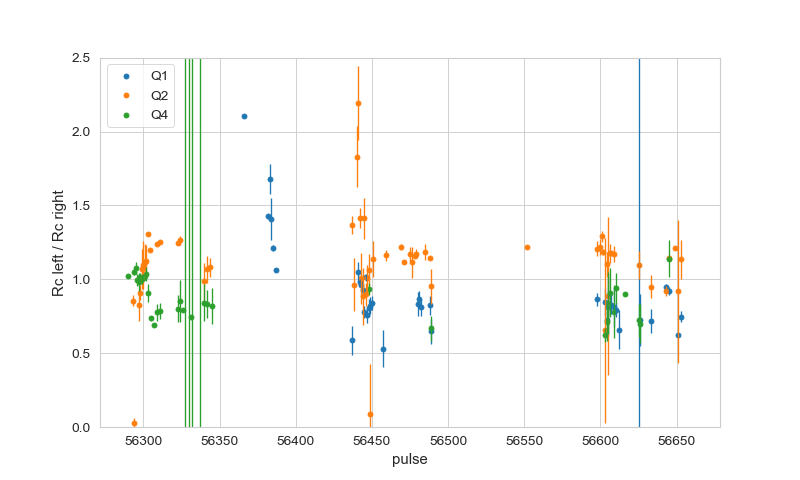

Text(0, 0.5, 'Rc left / Rc right')

In [9]:
# means and errors values for each pulse
data_means = data.query('IC_P_tot > 0.2').groupby('pulse').mean().reset_index()
data_errors = data.query('IC_P_tot > 0.2').groupby('pulse').std().reset_index()

fig, ax = plt.subplots()

data_means.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q1_Rc_left_over_right', label='Q1', yerr=data_errors, color='C0')
data_means.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q2_Rc_left_over_right', label='Q2', yerr=data_errors, color='C1')
data_means.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q4_Rc_left_over_right', label='Q4', yerr=data_errors, color='C2')

ax.set_ylim(bottom=0, top=2.5)
ax.set_ylabel('Rc left / Rc right')


<IPython.core.display.Javascript object>


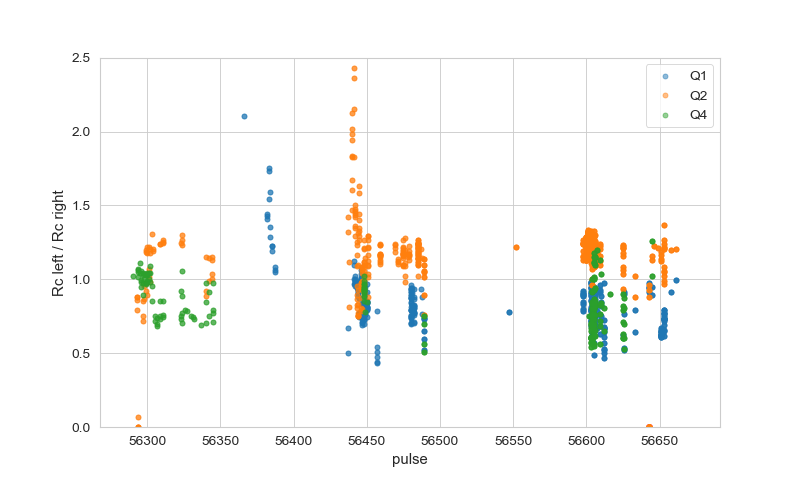

Text(0, 0.5, 'Rc left / Rc right')

In [10]:
fig, ax = plt.subplots()

data.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q1_Rc_left_over_right', label='Q1', color='C0', alpha=0.5)
data.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q2_Rc_left_over_right', label='Q2', color='C1', alpha=0.5)
data.plot(kind='scatter', ax=ax, x='pulse', y='IC_Q4_Rc_left_over_right', label='Q4', color='C2', alpha=0.5)

ax.set_ylim(bottom=0, top=2.5)
ax.set_ylabel('Rc left / Rc right')

In [11]:
import seaborn as sns

<IPython.core.display.Javascript object>


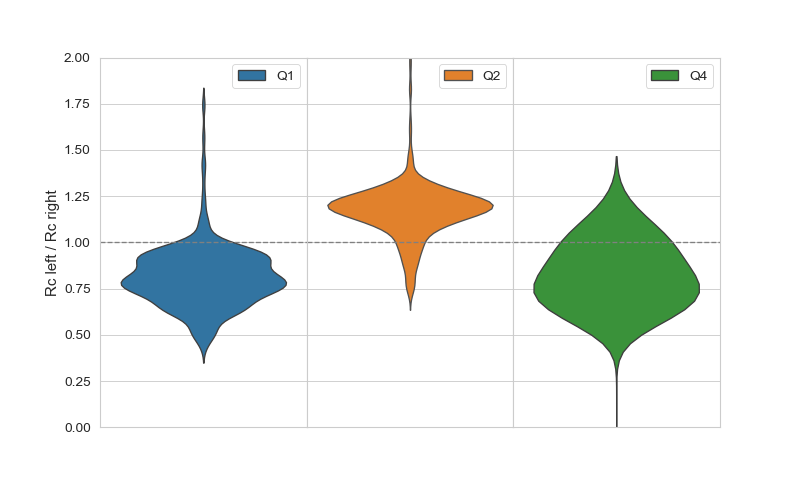

In [12]:
fig, ax = plt.subplots(1,3,sharey=True)
sns.violinplot(ax=ax[0], y='IC_Q1_Rc_left_over_right', data=data.query('IC_Rc_Q1_avg > 0.5'), color='C0', inner=None, label='Q1')
sns.violinplot(ax=ax[1], y='IC_Q2_Rc_left_over_right', data=data.query('IC_Rc_Q2_avg > 0.5'), color='C1', inner=None, label='Q2')
sns.violinplot(ax=ax[2], y='IC_Q4_Rc_left_over_right', data=data.query('IC_Rc_Q4_avg > 0.5'), color='C2', inner=None, label='Q4')
ax[0].set_ylim(0, 2) 
fig.subplots_adjust(wspace=0)
ax[1].set_ylabel(''); ax[2].set_ylabel('')
ax[0].set_ylabel('Rc left / Rc right')
[a.legend([f'Q{ant}']) for a,ant in zip(ax, ['1', '2', '4'])]
[a.axhline(1, ls='--', color='gray') for a in ax]

<IPython.core.display.Javascript object>


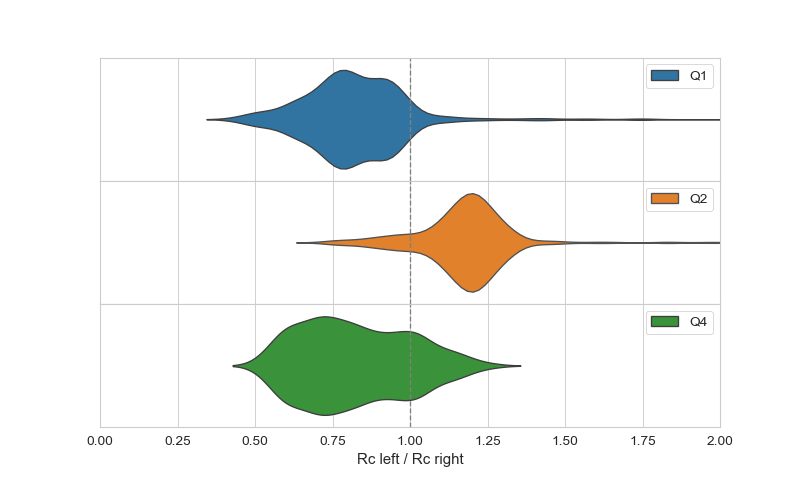

In [67]:
# means and errors values for each pulse
data_means_Q1 = data.query('IC_P_Q1 > 0.2').groupby('pulse').mean().reset_index()
data_means_Q2 = data.query('IC_P_Q2 > 0.2').groupby('pulse').mean().reset_index()
data_means_Q4 = data.query('IC_P_Q4 > 0.2').groupby('pulse').mean().reset_index()

fig, ax = plt.subplots(3,1,sharex=True)
sns.violinplot(ax=ax[0], x='IC_Q1_Rc_left_over_right', data=data.query('IC_P_Q1 > 0.2'), color='C0', inner=None, label='Q1')
sns.violinplot(ax=ax[1], x='IC_Q2_Rc_left_over_right', data=data.query('IC_P_Q2 > 0.2'), color='C1', inner=None, label='Q2')
sns.violinplot(ax=ax[2], x='IC_Q4_Rc_left_over_right', data=data.query('IC_P_Q4 > 0.2'), color='C2', inner=None, label='Q4')
ax[0].set_xlim(0, 2) 
fig.subplots_adjust(hspace=0)
ax[0].set_xlabel(''); ax[1].set_ylabel('')
ax[-1].set_xlabel('Rc left / Rc right')
[a.legend([f'Q{ant}']) for a,ant in zip(ax, ['1', '2', '4'])]
[a.axvline(1, ls='--', color='gray') for a in ax]

# Impurity Content Evolution

<IPython.core.display.Javascript object>


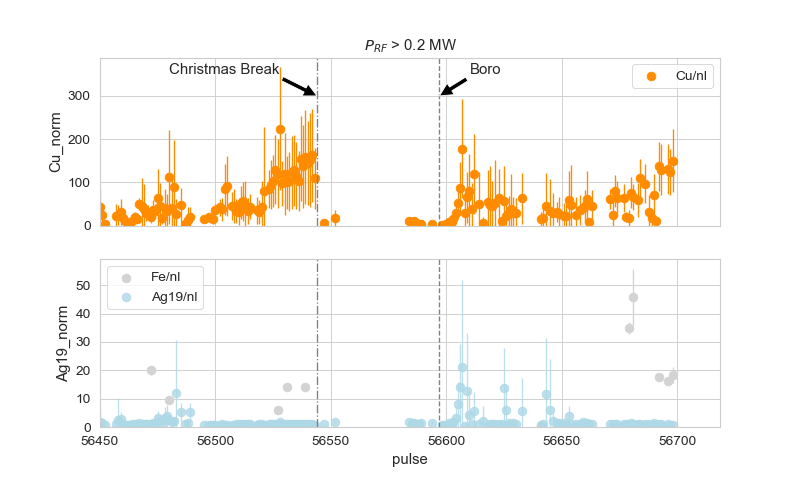

Text(56610, 350, 'Boro')

In [62]:
# means and errors values for each pulse
data_means = data.groupby('pulse').mean().reset_index()
data_errors = data.groupby('pulse').std().reset_index()

fig, ax = plt.subplots(2, 1, sharex=True)

data_means.plot(ax=ax[0], kind='scatter', 
                x='pulse', y='Cu_norm', yerr=data_errors,
               color='darkorange', label='Cu/nl', s=60)

data_means.plot(ax=ax[1], kind='scatter', 
                x='pulse', y='Fe_norm', yerr=data_errors,
               color='lightgray', label='Fe/nl', s=60, alpha=1)
data_means.plot(ax=ax[1], kind='scatter', 
                x='pulse', y='Ag19_norm', yerr=data_errors,
               color='lightblue', label='Ag19/nl', s=60, alpha=0.8)


ax[0].set_xlim(left=56450)
ax[0].set_title('$P_{RF}$ > 0.2 MW')
[a.set_ylim(bottom=0) for a in ax]

[[a.axvline(shot, ls='--', color='gray') for shot in post_boro] for a in ax]
[a.axvline(january_restart, ls='-.', color='gray') for a in ax]
ax[0].annotate('Christmas Break', xy=(56544, 300), xytext=(56480, 350), 
            arrowprops=dict(facecolor='black'))

ax[0].annotate('Boro', xy=(56597, 300), xytext=(56610, 350), 
            arrowprops=dict(facecolor='black'))


# Isotopic Ratio vs ...

<IPython.core.display.Javascript object>


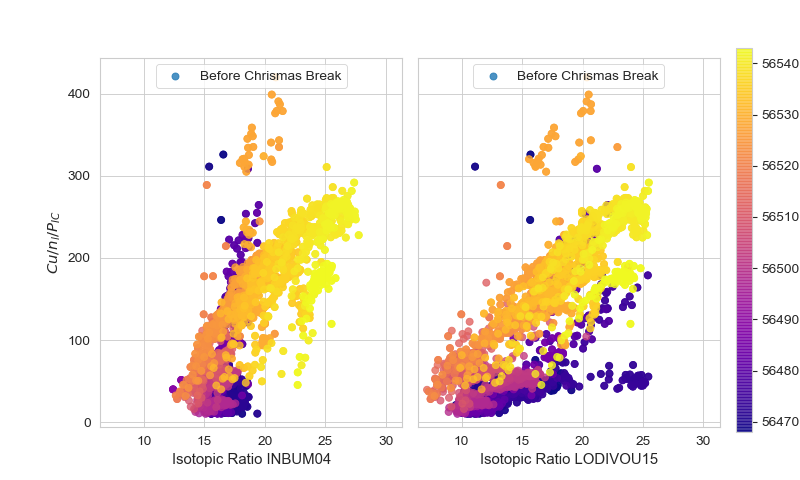

In [273]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
# INBUM04 ou LODIVOU15

# Boros : 56247, 56641
data.query(f'P_RF > 0.3 & Cu_norm > 10 & pulse < {january_restart} & `Isotopic Ratio INBUM04`>0').plot(ax=ax[0], kind='scatter', 
                                x='Isotopic Ratio INBUM04', y='Cu_norm', 
                                c='pulse', cmap='plasma', alpha=0.8, s=40, label='Before Chrismas Break', colorbar=False)
data.query(f'P_RF > 0.3 & Cu_norm > 10 & pulse < {january_restart} & `Isotopic Ratio INBUM04`>0').plot(ax=ax[1], kind='scatter', 
                                x='Isotopic Ratio LODIVOU15', y='Cu_norm', 
                                c='pulse', cmap='plasma', alpha=0.8, s=40, label='Before Chrismas Break', colorbar=False)
im = plt.gca().get_children()[0]
cax = fig.add_axes([0.92,0.1,0.02,0.8]) 
fig.colorbar(im, cax=cax)

[a.set_xlim(0, 25) for a in ax]
[a.set_ylim(bottom=0, top=450) for a in ax]
[a.legend(loc='upper center') for a in ax]
[a.set_ylabel('$Cu/n_l/P_{IC}$') for a in ax]
fig.subplots_adjust(wspace=0.05)
#fig.tight_layout()

<IPython.core.display.Javascript object>


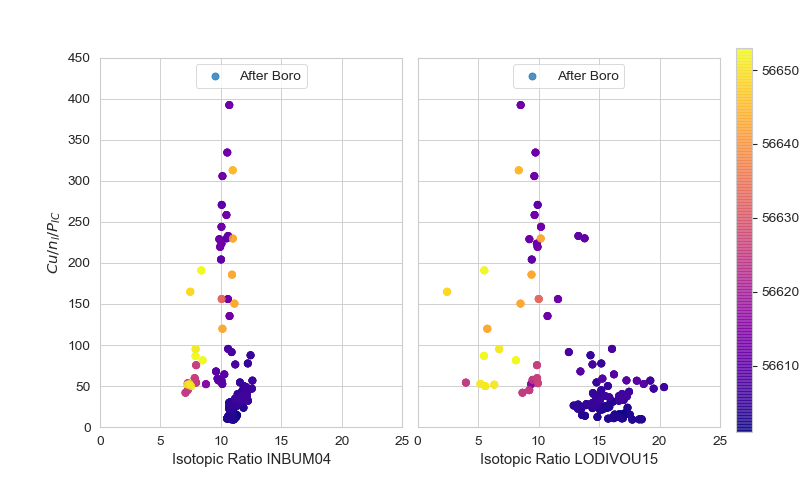

In [270]:
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)
# INBUM04 ou LODIVOU15

# Boros : 56247, 56641
data.query(f'P_RF > 0.3 & Cu_norm > 10 & pulse > {post_boro[1]} & `Isotopic Ratio INBUM04`>0').plot(ax=ax[0], kind='scatter', 
                                x='Isotopic Ratio INBUM04', y='Cu_norm_nl_IC', 
                                c='pulse', cmap='plasma', alpha=0.8, s=40, label='After Boro', colorbar=False)
data.query(f'P_RF > 0.3 & Cu_norm > 10 & pulse > {post_boro[1]} & `Isotopic Ratio INBUM04`>0').plot(ax=ax[1], kind='scatter', 
                                x='Isotopic Ratio LODIVOU15', y='Cu_norm_nl_IC', 
                                c='pulse', cmap='plasma', alpha=0.8, s=40, label='After Boro', colorbar=False)
im = plt.gca().get_children()[0]
cax = fig.add_axes([0.92,0.1,0.02,0.8]) 
fig.colorbar(im, cax=cax)

[a.set_xlim(0, 25) for a in ax]
[a.set_ylim(bottom=0, top=450) for a in ax]
[a.legend(loc='upper center') for a in ax]
[a.set_ylabel('$Cu/n_l/P_{IC}$') for a in ax]
fig.subplots_adjust(wspace=0.05)
#fig.tight_layout()

# Evolution du rapport isotopique

<IPython.core.display.Javascript object>


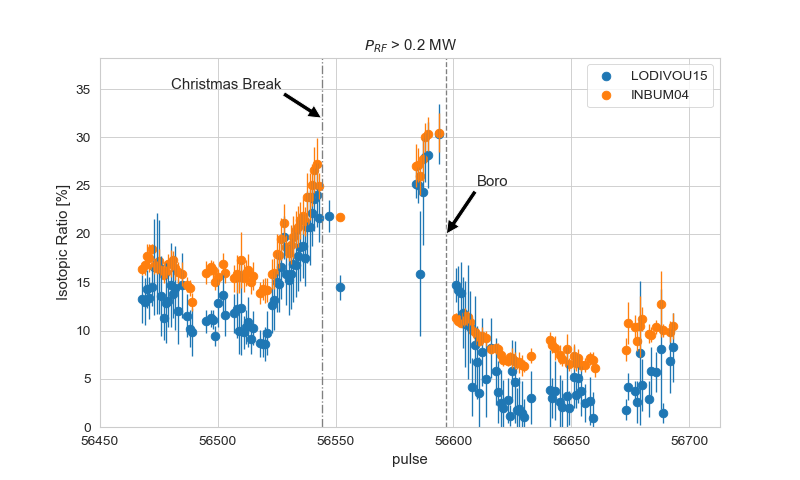

Text(56610, 25, 'Boro')

In [19]:
fig, ax = plt.subplots()
data_means = data.groupby('pulse').mean().reset_index()
data_errors = data.groupby('pulse').std().reset_index()

data_means.query('`Isotopic Ratio LODIVOU15`>0').plot(ax=ax, kind='scatter', 
                x='pulse', y='Isotopic Ratio LODIVOU15', yerr=data_errors,
               color='C0', label='LODIVOU15', s=60)
data_means.query('`Isotopic Ratio INBUM04`>0').plot(ax=ax, kind='scatter', 
                x='pulse', y='Isotopic Ratio INBUM04', yerr=data_errors,
               color='C1', label='INBUM04', s=60)
ax.set_xlim(left=56450)

ax.axvline(january_restart, ls='-.', color='gray')

[ax.axvline(shot, ls='--', color='gray') for shot in post_boro]

ax.set_title('$P_{RF}$ > 0.2 MW')
ax.set_ylim(bottom=0)
ax.set_ylabel('Isotopic Ratio [%]')
ax.annotate('Christmas Break', xy=(56544, 32), xytext=(56480, 35), 
            arrowprops=dict(facecolor='black'))

ax.annotate('Boro', xy=(56597, 20), xytext=(56610, 25), 
            arrowprops=dict(facecolor='black'))


# Fitting to Power Scaling Laws

In [239]:
data.columns

Index(['Unnamed: 0', 'Ag18', 'Ag19', 'Cu', 'Datetime', 'Fe', 'IC_Frequencies',
       'IC_P_Q1', 'IC_P_Q2', 'IC_P_Q4', 'IC_P_tot', 'IC_Positions',
       'IC_Rc_Q1_avg', 'IC_Rc_Q2_avg', 'IC_Rc_Q4_avg',
       'IC_Voltage_left_lower_Q1', 'IC_Voltage_left_lower_Q2',
       'IC_Voltage_left_lower_Q4', 'IC_Voltage_left_upper_Q1',
       'IC_Voltage_left_upper_Q2', 'IC_Voltage_left_upper_Q4',
       'IC_Voltage_right_lower_Q1', 'IC_Voltage_right_lower_Q2',
       'IC_Voltage_right_lower_Q4', 'IC_Voltage_right_upper_Q1',
       'IC_Voltage_right_upper_Q2', 'IC_Voltage_right_upper_Q4', 'Ip',
       'Isotopic Ratio INBUM04', 'Isotopic Ratio LODIVIN15',
       'Isotopic Ratio LODIVOU15', 'LH_P_tot', 'LH_Positions', 'MHD',
       'Ohmic_P', 'Prad', 'R_LH1', 'R_LH2', 'R_Q1', 'R_Q2', 'R_Q4',
       'Rext_median', 'Separatrix_P', 'day', 'freq_Q1', 'freq_Q2', 'freq_Q4',
       'month', 'nl', 'pulse', 'time', 'year', 'P_RF', 'Ptot', 'P_conv',
       'frad', 'Cu_norm', 'Ag18_norm', 'Ag19_norm', 'Cu_no

In [96]:
from sklearn import linear_model

In [265]:
# let's first filter only the usefull data from the whole dataset
signames = ['Cu_norm','IC_P_Q1', 'IC_P_Q2', 'IC_P_Q4', 'LH_P_tot']
query = f' IC_P_tot > 0.3 & Cu_norm > 10'
# Convert into log values and remove spurious points
data_log = data.query(query)[signames].apply(np.log).replace([np.inf, -np.inf], np.nan).dropna()

# Make a linear regression on the log values
lin_reg = linear_model.LinearRegression()
lin_reg.fit(data_log[signames[1:]], data_log[signames[0]])
coefs = np.squeeze(lin_reg.coef_)

print(f'Scaling coefficients: a={coefs}')
print(f'Intersection A: {lin_reg.intercept_}')

Scaling coefficients: a=[ 1.44864712 -0.81490194  0.06491579 -0.02995621]
Intersection A: 4.979258801161136


In [266]:
def power_law(signames, coefs, A0, query='index == index or index != index'):
    y = A0
    for (signame, coef) in zip(signames[1:], coefs):
        y *= data.query(query)[signame]**coef
    return y

<IPython.core.display.Javascript object>


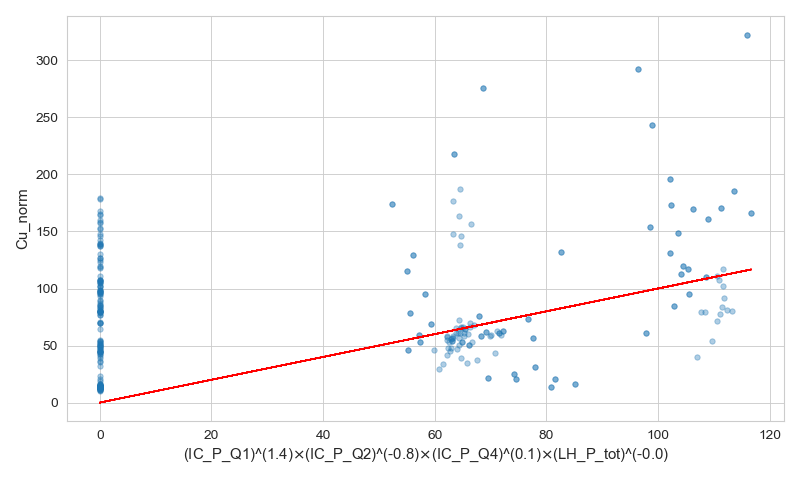

In [267]:
Cu_scale = power_law(signames, coefs, np.exp(lin_reg.intercept_), query=query)

fig, ax = plt.subplots()
ax.scatter(Cu_scale, data.query(query)['Cu_norm'], alpha=0.2)
ax.plot(Cu_scale, Cu_scale, color='r')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True, which='minor')
ax.set_xlabel(r'$ \times $'.join([f'({signame})^({coef:.1f})' for (signame, coef) in zip(signames[1:], coefs)]))
ax.set_ylabel('Cu_norm')
fig.tight_layout()


# Correlation Matrix

<IPython.core.display.Javascript object>


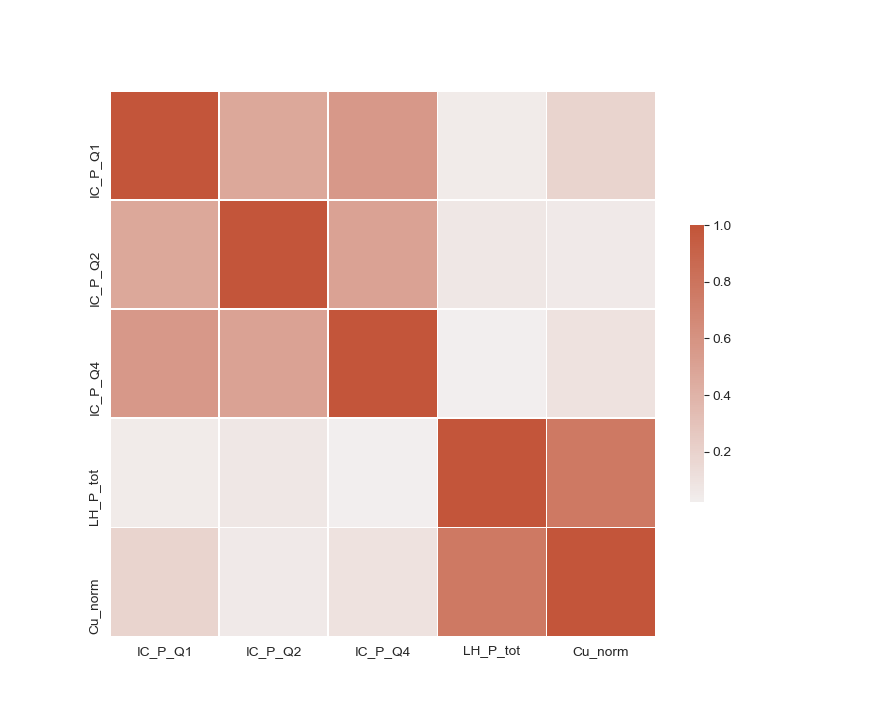

<AxesSubplot:>

In [264]:
import seaborn as sns

# Compute the correlation matrix
corr = data[['IC_P_Q1', 'IC_P_Q2', 'IC_P_Q4', 'LH_P_tot', 'Cu_norm']].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Statistics

In [7]:
fig, ax = plt.subplots()
data.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q1', label='Q1', color='C0')
data.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q2', label='Q2', color='C1')
data.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_Q4', label='Q4', color='C2')
#data.plot(ax=ax, kind='scatter', x='pulse', y='IC_P_tot', label='Total IC', color='gray')


2021-01-12 12:33:14,557 matplotlib.backend_managers WARNING  Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='pulse', ylabel='IC_P_Q4'>

## Evolution of the Copper Impurity

In [16]:
with plt.style.context('ggplot'):
    fig, axes = plt.subplots(2, 1, sharex=True)
    data.query('IC_P_tot>0.25').plot(kind='scatter', x='pulse', y='Cu_norm_nl_IC', c='Ip', ax=axes[0], cmap="viridis", s=50, vmax=0.75, alpha=.6)
    data.query('LH_P_tot>0.25').plot(kind='scatter', x='pulse', y='Cu_norm_nl_LH', c='Ip', ax=axes[1], cmap="viridis", s=50, vmax=0.75, alpha=.6)
    [ax.set_ylim(bottom=0, top=500) for ax in axes]
    axes[0].set_ylabel('Cu / nl / IC Power [a.u.]')
    axes[1].set_ylabel('Cu / nl / LH Power [a.u.]')
    axes[-1].set_xlabel('WEST Pulse #')
    #plt.xticks(rotation=40)
    fig.suptitle('Evolution of Copper Impurity')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2)
    axes[-1].xaxis.tick_top()

2020-12-22 12:31:03,900 matplotlib.backend_managers WARNING  Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Isotopic Ratio

In [17]:
fix, ax = plt.subplots()
data.plot(ax=ax, kind='scatter', x='pulse', y='Isotopic Ratio')

2020-12-22 12:31:48,517 matplotlib.backend_managers WARNING  Treat the new Tool classes introduced in v1.5 as experimental for now, the API will likely change in version 2.1 and perhaps the rcParam as well


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='pulse', ylabel='Isotopic Ratio'>

## Other Derived Quantities

In [15]:
data['Rext_median_NICE_mm'] = data['Rext_median_NICE']*1e3
data['Rext_upper_NICE_mm'] = data['Rext_upper_NICE']*1e3
data['Rext_lower_NICE_mm'] = data['Rext_lower_NICE']*1e3
# 1st object found at LFS in [mm]
data['Robj'] = data[['R_Q1', 'R_Q2', 'R_Q4', 'LH_Positions', 'LPA']].min(axis=1)*1e3
# ROG wrt VACTH magnetic reconstruction in [mm]
data['ROG_LH'] =  - data['Rext_median']
data['ROG_Q1'] = data['R_Q1']*1e3 - data['Rext_median']
data['ROG_Q2'] = data['R_Q2']*1e3 - data['Rext_median']
data['ROG_Q4'] = data['R_Q4']*1e3 - data['Rext_median']
data['ROG'] = data['Robj'] - data['Rext_median']
data['ROG_upper'] = data['Robj'] - data['Rext_upper']
data['ROG_lower'] = data['Robj'] - data['Rext_lower']
# ROG wrt NICE magnetic reconstruction in [mm]
data['ROG_Q1_NICE'] = data['R_Q1']*1e3 - data['Rext_median_NICE_mm']
data['ROG_Q2_NICE'] = data['R_Q2']*1e3 - data['Rext_median_NICE_mm']
data['ROG_Q4_NICE'] = data['R_Q4']*1e3 - data['Rext_median_NICE_mm']
data['ROG_NICE'] = data['Robj'] - data['Rext_median_NICE_mm']
data['ROG_upper_NICE'] = data['Robj'] - data['Rext_upper_NICE_mm']
data['ROG_lower_NICE'] = data['Robj'] - data['Rext_lower_NICE_mm']

KeyError: 'Rext_median_NICE'

In [10]:
data['P_conv_ratio'] = data['P_conv']/(data['IC_P_tot'])

In [11]:
# Define USN.LSN plasma configuration
data['Xpoint'] = 'LSN'  # default plasma are LSN, only a few listed below are USN
USN_list = np.r_[55227, 55174, 55173, 55172, 55171, 55170]
USN_list = np.append(USN_list, np.arange(54882, 54892))
USN_list = np.append(USN_list, np.arange(54894, 54903))
USN_list = np.append(USN_list, np.load('USN_pulse.npy'))  # List by J.Morales
USN_list = np.unique(USN_list)
print(USN_list)
data.loc[data['pulse'].isin(USN_list), 'Xpoint'] = 'USN'

# first shot after boronization
after_boro_shot = [53453, 54288, 54403, 54502, 54596, 54719, 54881, 55000, 55138, 55499, 55548, 55747, 55795]


[54882 54883 54884 54885 54886 54887 54888 54889 54890 54891 54894 54895
 54896 54897 54898 54899 54900 54901 54902 54976 54977 54978 54982 54984
 54986 54987 54989 54991 55000 55001 55002 55004 55006 55008 55170 55171
 55172 55173 55174 55227 55568 55599 55600 55601 55602 55603 55604 55606
 55607 55610 55614 55621 55628 55635 55636 55638 55639 55640 55643 55644
 55646 55647 55648 55651 55652 55656 55657 55659 55662 55675 55684 55686
 55687 55688 55728 55733 55736 55780 55781 55782 55783 55784 55785 55786
 55787 55789 55790 55791 55792 55794]


In [12]:
# distance to closest boto
def closest_boro(pulse, boro_shots=after_boro_shot):
    '''
    Get  to the closest1st  pulse after boronization pulse (only previous pulse, not future one!) 
    '''
    return after_boro_shot[np.where(pulse - np.array(after_boro_shot)  >= 0)[0][-1]]

data['closest_boro'] = data['pulse'].apply(closest_boro)
data['distance_boro'] = data['pulse'] - data['closest_boro']

In [13]:
data['Lang_LH1_avg'] = (data['Langmuir_LHCD1'] + data['Langmuir_LHCD2'] + data['Langmuir_LHCD3'] + data['Langmuir_LHCD4'])/4
data['Lang_LH2_avg'] = (data['Langmuir_LHCD5'] + data['Langmuir_LHCD6'] + data['Langmuir_LHCD7'] + data['Langmuir_LHCD8'])/4
data['ne_LH1_sur_nl'] = data['Lang_LH1_avg'] / data['nl']
data['ne_LH2_sur_nl'] = data['Lang_LH2_avg'] / data['nl']

# C4 Statistics

In [14]:
fig, ax = plt.subplots(3,1,sharex=True)
data.query('IC_P_Q1 > 100').hist('IC_P_Q1', ax=ax[0], bins=100, label='Q1')
data.query('IC_P_Q2 > 100').hist('IC_P_Q2', ax=ax[1], bins=100, label='Q2', color='C1')
data.query('IC_P_Q4 > 100').hist('IC_P_Q4', ax=ax[2], bins=100, label='Q4', color='C2')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:title={'center':'IC_P_Q4'}>], dtype=object)

In [21]:
fig, ax = plt.subplots()
data.query('IC_P_Q2 > 1000').plot(kind='scatter', ax=ax, x='pulse', y='IC_P_Q2')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='pulse', ylabel='IC_P_Q2'>

In [15]:
tmin_Q1 = data.query('IC_P_Q1 > 100').groupby('pulse')['time'].min()
tmax_Q1 = data.query('IC_P_Q1 > 100').groupby('pulse')['time'].max()
duration_Q1 = tmax_Q1 - tmin_Q1
Pmean_Q1 = data.query('IC_P_Q1 > 100').groupby('pulse')['IC_P_Q1'].mean()
Pstd_Q1 = data.query('IC_P_Q1 > 100').groupby('pulse')['IC_P_Q1'].std()
pulses_Q1 = data.query('IC_P_Q1 > 100')['pulse'].unique()

tmin_Q2 = data.query('IC_P_Q2 > 100').groupby('pulse')['time'].min()
tmax_Q2 = data.query('IC_P_Q2 > 100').groupby('pulse')['time'].max()
duration_Q2 = tmax_Q2 - tmin_Q2
Pmean_Q2 = data.query('IC_P_Q2 > 100').groupby('pulse')['IC_P_Q2'].mean()
Pstd_Q2 = data.query('IC_P_Q2 > 100').groupby('pulse')['IC_P_Q2'].std()
pulses_Q2 = data.query('IC_P_Q2 > 100')['pulse'].unique()

tmin_Q4 = data.query('IC_P_Q4 > 100').groupby('pulse')['time'].min()
tmax_Q4 = data.query('IC_P_Q4 > 100').groupby('pulse')['time'].max()
duration_Q4 = tmax_Q4 - tmin_Q4
Pmean_Q4 = data.query('IC_P_Q4 > 100').groupby('pulse')['IC_P_Q4'].mean()
Pstd_Q4 = data.query('IC_P_Q4 > 100').groupby('pulse')['IC_P_Q4'].std()
pulses_Q4 = data.query('IC_P_Q4 > 100')['pulse'].unique()


In [16]:
data['IC_P_Q4'].max()

2063.708193920637

In [17]:
fig, ax = plt.subplots()
ax.plot(duration_Q1, Pmean_Q1, '.', ms=10, color='C0', label='Q1')
ax.plot(duration_Q2, Pmean_Q2, '.', ms=10, color='C1', label='Q2')
ax.plot(duration_Q4, Pmean_Q4, '.', ms=10, color='C2', label='Q4')
ax.legend()
ax.set_xlabel('RF Duration [s]', fontsize=14)
ax.set_ylabel('RF Average Coupler Power [kW]', fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'RF Average Coupler Power [kW]')

In [18]:
fig, ax = plt.subplots()
data.groupby('pulse').max().reset_index().plot(x='time', y='IC_P_tot', ax=ax, kind='scatter')
ax.legend()
ax.set_xlabel('Pulse', fontsize=14)
ax.set_ylabel('Total RFCoupler Power [MW]', fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Total RFCoupler Power [MW]')

In [33]:
fig, ax = plt.subplots()
ax.errorbar(pulses_Q1, Pmean_Q1, yerr=Pstd_Q1, ls='', marker='.', ms=10, color='C0', label='Q1', alpha=0.6)
ax.errorbar(pulses_Q2, Pmean_Q2, yerr=Pstd_Q2, ls='', marker='.', ms=10, color='C1', label='Q2', alpha=0.6)
ax.errorbar(pulses_Q4, Pmean_Q4, yerr=Pstd_Q4, ls='', marker='.', ms=10, color='C2', label='Q4', alpha=0.6)
ax.legend(fontsize=18)
ax.set_xlabel('WEST Pulse #', fontsize=18)
ax.set_ylabel('RF Average Coupler Power [kW]', fontsize=18)
ax.set_ylim(bottom=0)
ax.tick_params(labelsize=18)
fig.tight_layout()
fig.savefig('WEST_C4_IC_RFcoupled-power_vs_pulse.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: __delete__

In [34]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 10')['IC_P_Q1'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 10')['IC_P_Q2'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 10')['IC_P_Q4'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_ylabel('Coupled Power [kW]', fontsize=18)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'))
ax.tick_params(labelsize=18)
ax.set_title('WEST C4', fontsize=18)
ax.grid(True)
fig.tight_layout()
fig.savefig('WEST_C4_IC_RFcoupled-power.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


AttributeError: __delete__

In [35]:
fig, ax = plt.subplots()
ax.violinplot(duration_Q1, [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(duration_Q2, [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(duration_Q4, [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_ylabel('RF Power Duration [s]', fontsize=16)
ax.set_xticklabels(('', f'Q1\n{len(duration_Q1)} shots', '', f'Q2\n{len(duration_Q2)} shots', '', f'Q4\n{len(duration_Q4)} shots'), fontsize=18)
ax.tick_params(labelsize=18)
ax.set_title('WEST C4', fontsize=18)
ax.grid(True)
fig.tight_layout()
fig.savefig('WEST_C4_IC_RFdurations.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


AttributeError: __delete__

# Langmuir Probe

In [36]:
P_min = 0.5e3
Xpoint = "LSN"
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200
Rext_median_max = 3100
P_LH_max = 5
MHD_pulses = [54582, 54721, 55026, 55029, 55034, 55050, 55052, 55067, 55069, 55178, 55561, 55564, 55797]
LH_antenna = 'LH2'

dataset = data.query('IC_P_tot < 0.1 and LH_P_tot > 0.1')\
            .query('Xpoint=="LSN"')\
            .query('ROG > -10 and ROG < 100')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('Rext_median < @Rext_median_max')\
            .query('pulse not in @MHD_pulses')\
            .query('MHD < 100')

fig, ax = plt.subplots(figsize=(8,6))

if LH_antenna == 'LH1':
    dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='ne_LH1_sur_nl', c='nl', cmap='winter', s=20, alpha=0.4, label='LH1')
else:
    dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='ne_LH2_sur_nl', c='nl', cmap='winter', s=20, alpha=0.4, label="LH2")

ax.set_ylim(0,4)
ax.set_xlabel('LH Power [MW]', fontsize=16)
ax.set_ylabel('$<I_{sat,LH}>/n_l$ [a.u]', fontsize=16)
ax.set_title(f'{LH_antenna} Langmuir Probes, IC Power < 100 kW \n LSN plasmas - $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] -\n  Rext<{Rext_median_max/1e3}m', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()

cax = plt.gcf().get_axes()[1]
cax.set_ylabel('$n_l$', fontsize=18)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(692.5027777777779, 0.5, '$n_l$')

In [37]:
dataset = data.query('IC_P_tot > 0.5 and LH_P_tot > 0.1')\
            .query('Xpoint=="LSN"')\
            .query('ROG > -10 and ROG < 100')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('Rext_median < @Rext_median_max')\
            .query('pulse not in @MHD_pulses')\
            .query('MHD < 80')

fig, ax = plt.subplots(figsize=(8,6))


dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='IC_Rc_Q1_avg', s=50, color='C0', alpha=0.4, label="Q1", marker='s')
dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='IC_Rc_Q2_avg', s=50, color='C1', alpha=0.4, label="Q2", marker='o')
dataset.plot(ax=ax, kind='scatter', x='LH_P_tot', y='IC_Rc_Q4_avg', s=50,  alpha=0.4, label="Q4", color='C2', marker='^')

ax.set_ylim(0.25,2)
ax.set_xlabel('LH Power [MW]', fontsize=18)
ax.set_ylabel('$R_c$ [$\Omega$]', fontsize=18)
ax.set_title(f'{LH_antenna} IC Power > 500 kW \n LSN plasmas - $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] -\n  Rext<{Rext_median_max/1e3}m', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()

# cax = plt.gcf().get_axes()[1]
# cax.set_ylabel('$n_l$', fontsize=18)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
P_RF_min = 1
Xpoint = "LSN"
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200
Rext_median_max = 3100
P_LH_max = 5
MHD_pulses = [54582, 54721, 55026, 55029, 55034, 55050, 55052, 55067, 55069, 55178, 55561, 55564, 55797]
LH_antenna = 'LH1'

dataset = data.query('P_RF > @P_RF_min')\
            .query('P_conv > 1.5')\
            .query('Xpoint=="LSN"')\
            .query('ROG > -10 and ROG < 100')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('Rext_median < @Rext_median_max')\
            .query('pulse not in @MHD_pulses')\
            .query('MHD < 70')\
            .query('Rext_median < @Rext_median_max')

fig, ax = plt.subplots()
params = {'axes.labelsize': 18,
          'axes.titlesize': 16}
plt.rcParams.update(params)

dataset.plot(ax=ax, kind='scatter', x='ROG_NICE', y='frad_bulk', c='P_conv', cmap='viridis', 
                 s=30, vmax=3, alpha=0.5);
ax.set_title(f'RF Power > {P_RF_min} MW \n LSN plasmas - $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] -\n  Rext<{Rext_median_max/1e3}m', fontsize=16)
ax.set_ylim(0.15, 0.8)
ax.set_xlim(-5,90)
cax = plt.gcf().get_axes()[1]
cax.set_ylabel('P_SEP [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Max Powers

In [39]:
test = data.query('IC_P_tot > 0.100 or LH_P_tot > 0.2').groupby('pulse').max()

In [40]:
test['pulse'] = test.index
test['P_IC'] = test['IC_P_tot']

In [41]:
fig, ax = plt.subplots()
test.plot(kind='scatter', x='pulse', y='LH_P_tot', s=60, ax=ax, c='C0', alpha=.8, label='LHCD')
test.plot(kind='scatter', x='pulse', y='P_IC', s=60, ax=ax, c='C1', alpha=.8, label='ICRH')

ax.set_xlabel('pulse #', fontsize=16)
ax.set_ylabel('Coupled Power [MW]', fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylim(0,6)
ax.legend(fontsize=16)
fig.tight_layout()

#fig.savefig('WEST_C4_LHCD_ICRH_max_power.png', dpi=150)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Link between radiated power and LCFS radius

In [42]:
# list oll 5 fives shots made after a boro
N = 5
pulses = data['pulse'].unique()

after_Nboro_pulses = []

for pulse_after_boro in after_boro_shot:
    # choc apres boro
    after_Nboro_pulses.append(pulse_after_boro)
    # N-1 chocs apres boro
    idx = np.argmin(np.abs(pulses - pulse_after_boro)) 
    after_Nboro_pulses.append(pulses[idx:idx+N])


In [43]:
Xpoint = "LSN"
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.5
phase_min=160
phase_max = 200
Rext_median_max = 3100
P_LH_max = 5

dataset = data.query('IC_P_tot > 0 or LH_P_tot > 0.0')\
            .query('Xpoint=="LSN"')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('P_conv > 1.0')\
            .query('frad_bulk > 0.1')\
            .query('pulse != @after_boro_shot')\
            .query('MHD < 100')

dataset_mean = dataset.groupby('pulse').mean()
dataset_std = dataset.groupby('pulse').std()
dataset_max = dataset.groupby('pulse').max()

dataset_mean['pulse'] = dataset_mean.index 
dataset_mean['Cu_norm'] = dataset_mean['Cu']/dataset_mean['nl']/dataset_mean['Ptot']

fig,ax = plt.subplots()
dataset_mean.plot(ax=ax, kind="scatter", x='pulse',  y='frad', 
                  c=dataset_max['P_RF'], cmap='viridis', 
                  yerr=dataset_std['frad_bulk'], alpha=0.5, s=50)

ax.set_ylim(0.3, 0.8)

for boro in after_boro_shot[2:]:
    ax.axvline(boro, color='k', ls='--', alpha=0.8)
    
ax.set_ylabel('<frad> ', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'WEST pulse #')

In [44]:
fig, ax = plt.subplots(2,1,sharex=True)
for (idx, Xpoint) in enumerate(['LSN', 'USN']):
    data.query('ROG_NICE>-5 and ROG_NICE < 100 and ROG < 100 and Xpoint==@Xpoint').hist('Rext_median', bins=200, ax=ax[idx], alpha=0.5, label='VacTH')
    data.query('ROG_NICE>-5 and ROG_NICE < 100 and ROG < 100 and Xpoint==@Xpoint and Rext_median_NICE_mm < 3000').hist('Rext_median_NICE_mm', bins=200, color='C1', ax=ax[idx], alpha=0.5, label='NICE')
    ax[idx].legend()
    ax[idx].set_title(f'WEST C4 - {Xpoint} plasmas')
    ax[idx].set_xlim(2850, 3020)
ax[-1].set_xlabel('Rext median [mm]', fontsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Rext median [mm]')

In [45]:
fig, ax = plt.subplots()
data.query('ROG_NICE>-5 and ROG_NICE < 100 and ROG < 100 and Xpoint=="LSN" ').plot(y='Rext_median_NICE_mm', x='Rext_median',kind='scatter', ax=ax, alpha=0.5, label='LSN', color='C0')
data.query('ROG_NICE>-5 and ROG_NICE < 100 and ROG < 100 and Xpoint=="USN" ').plot(y='Rext_median_NICE_mm', x='Rext_median',kind='scatter', ax=ax, alpha=0.5, label='USN', color='C1')

ax.plot([2900, 3020], [2900, 3020], color='k')
ax.set_xlabel('Rext median VACTH [mm]')
ax.set_ylabel('Rext median NICE [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Rext median NICE [mm]')

# Why does USN plasma increase coupling?

In [46]:
def Rc_theoretical(x, lambd, A):
    return A*np.exp(-x/lambd)

In [47]:
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200

P_IC_min = 200
P_LH_min = 0.1

dataset = data.query('IC_P_Q4 > @P_IC_min')\
            .query('LH_P_tot < @P_LH_min')\
            .query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 100')\
            .query('IC_Rc_Q4_avg > 0.5')\

In [48]:
fig, ax = plt.subplots()
dataset.query('Xpoint == "LSN"').plot(ax=ax, c='C0', kind='scatter', x='ROG_Q4_NICE', y='IC_Rc_Q4_avg', alpha=0.2, s=30)
dataset.query('Xpoint == "USN"').plot(ax=ax, c='C1', kind='scatter', x='ROG_Q4_NICE', y='IC_Rc_Q4_avg', alpha=0.2, s=30)
ax.set_xlim(-10, 80)
ax.set_xlabel('ROG (NICE) [mm]', fontsize=14)
ax.set_ylabel('Rc (Q4) [Ohm]', fontsize=14)
ax.set_title('4 ')
ax.set_title(f'Rc vs ROG (Q4) - WEST C4 -  $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] \n P_IC > {P_IC_min/1e3} MW - P_LH < {P_LH_min} MW - no MHD ', fontsize=16)
#ax.set_yscale('log')
ax.grid(True, which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
fig, ax = plt.subplots()
dataset.query(' Xpoint == "LSN" ').plot(ax=ax, c='C0', kind='scatter', x='ROG_Q4', y='IC_Rc_Q4_avg', alpha=0.2, s=30)
dataset.query(' Xpoint == "USN" ').plot(ax=ax, c='C1', kind='scatter', x='ROG_Q4', y='IC_Rc_Q4_avg', alpha=0.2, s=30)
ax.set_xlim(-10, 80)
ax.set_xlabel('ROG (VACTH) [mm]', fontsize=14)
ax.set_ylabel('Rc (Q4) [Ohm]', fontsize=14)
ax.set_title(f'Rc vs ROG (Q4) - WEST C4 -  $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] \n P_IC > {P_IC_min/1e3} MW - P_LH < {P_LH_min} MW - no MHD ', fontsize=16)

# ax.set_yscale('log')
ax.grid(True, which='minor')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Copper Impurity

In [50]:
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200

P_IC_min = 0.200
P_LH_min = 0.1

dataset = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 100')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('Rext_median < 2960 and Rext_median > 2900')\
            .query('IC_P_tot > 0')\
            .query('LH_P_tot > 0.1')\
            .query('Xpoint == "LSN"')


In [51]:
fig, ax = plt.subplots()
dataset.plot(ax=ax, kind='scatter', x='ROG_NICE', y='Cu_norm', 
            c='LH_P_tot', cmap='viridis')
ax.set_ylim(0.1, 100)
ax.set_yscale('log')
ax.grid(True, which='minor')
ax.tick_params(labelsize=14)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Radiated Power vs ROG 

In [52]:
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200

P_IC_min = 0.2
P_conv_min = 2.0

dataset = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 80')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('IC_P_tot > @P_IC_min')\
            .query('Xpoint == "LSN"')\
            .query('P_conv > @P_conv_min')

fig, ax = plt.subplots()
dataset.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q1_avg', label="Q1",
             alpha=0.5, s=70, edgecolor='dimgray', color='C0')
dataset.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q2_avg', label="Q2",
             alpha=0.5, s=70, edgecolor='dimgray', color='C1')
dataset.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q4_avg', label="Q4",
             alpha=0.5, s=70, edgecolor='dimgray', color='C2')
ax.grid(True, which='minor')
ax.tick_params(labelsize=14)
ax.set_xlabel('ROG (NICE) [mm]', fontsize=16)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=16)
ax.set_title(f'WEST C4 -  LSN -  $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] \n P_IC > {P_IC_min} MW - P_LH > {P_LH_min} MW', fontsize=16)
ax.set_xlim(0, 80)
ax.set_ylim(bottom=0.3, top=2.5)
#cax = plt.gcf().get_axes()[1]
#cax.set_ylabel('$P_{\mathrm{sep}}$ [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [79]:
Ip_min = 480
Ip_max = 520
nl_min = 3.4
nl_max = 4.5
phase_min=170
phase_max = 190

P_IC_min = 0.2
P_conv_min = 1.0

dataset_LSN = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 80')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('IC_P_tot > @P_IC_min')\
            .query('Xpoint == "LSN"')\
            .query('P_conv > @P_conv_min').sort_values('P_conv', ascending=True)

dataset_USN = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 80')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('IC_P_tot > @P_IC_min')\
            .query('Xpoint == "USN"')\
            .query('P_conv > @P_conv_min').sort_values('P_conv', ascending=False)

fig, ax = plt.subplots()
dataset_LSN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q1_avg', label="Q1 LSN",
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis')
dataset_LSN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q2_avg', label="Q2 LSN",
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis', colorbar=False)
dataset_LSN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q4_avg', label="Q4 LSN",
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis', colorbar=False)

dataset_USN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q1_avg', label="Q1 USN", marker='^',
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis', colorbar=False)
dataset_USN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q2_avg', label="Q2 USN", marker='^',
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis', colorbar=False)
dataset_USN.plot(ax=ax, kind='scatter', x='ROG_NICE', y='IC_Rc_Q4_avg', label="Q4 USN", marker='^',
             alpha=0.5, s=40, edgecolor='dimgray', c='P_conv', cmap='viridis', colorbar=False)


ax.grid(True, which='minor')
ax.tick_params(labelsize=14)
ax.set_xlabel('ROG (NICE) [mm]', fontsize=16)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=16)
ax.set_title(f'WEST C4 -  $n_l\in$ [{nl_min};{nl_max}] - $I_p\in$ [{Ip_min};{Ip_max}] \n P_IC > {P_IC_min} MW - P_LH > {P_LH_min} MW; P_sep>{P_conv_min}MW', fontsize=16)
ax.set_xlim(0, 80)
ax.set_ylim(bottom=0.3, top=2.5)
#cax = plt.gcf().get_axes()[1]
#cax.set_ylabel('$P_{\mathrm{sep}}$ [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Silver Impurity

In [54]:
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200

P_IC_min = 0.500
P_LH_min = 0.5
P_conv_min = 2.0

dataset = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 80')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('IC_P_tot > @P_IC_min')\
            .query('LH_P_tot > @P_LH_min')\
            .query('Xpoint == "LSN"')\
            .query('P_conv > @P_conv_min')

fig, ax = plt.subplots()
dataset.plot(ax=ax, kind='scatter', x='pulse', y='Ag19')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='pulse', ylabel='Ag19'>

# Radiated Power vs pulse and Boronization

In [ ]:
dataset = data.groupby('pulse').max().reset_index()

In [ ]:
fig, ax = plt.subplots()
dataset.plot(ax=ax, kind='scatter', x='pulse', y='Prad')

for boro in after_boro_shot:
    ax.axvline(boro, ls='--', color='gray')
ax.set_xlim(left=54400)

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def fit_Prad( (a_ohm, a_LH, a_IC) ):
    

In [ ]:
Ip_min = 480
Ip_max = 520
nl_min = 3.0
nl_max = 5.0
phase_min=160
phase_max = 200

P_IC_min = 0.100
P_LH_min = 0.1

dataset = data.query('Ip > @Ip_min and Ip < @Ip_max')\
            .query('nl > @nl_min and nl < @nl_max')\
            .query('MHD < 80')\
            .query('ROG_NICE < 100 and ROG_NICE > 0')\
            .query('Xpoint == "LSN"')\
            .query('Ptot > 0')


fig, ax = plt.subplots()
dataset.plot(ax=ax, kind='scatter', x='Ptot', y='Prad', c='IC_P_tot', cmap='jet', edgecolor='dimgray', s=70, clim=(0,5e3))
ax.set_xlim(left=0)
ax.set_xlabel('Total Power (Ohmic+LH+IC) [MW]')
ax.set_ylabel('Radiated Power [MW]')
cax = plt.gcf().get_axes()[1]
cax.set_ylabel('IC Power [MW]', fontsize=14)

fig.tight_layout()
# dataset = dataset.groupby('pulse').max().reset_index()
# dataset.plot(ax=ax, kind='scatter', x='distance_boro', y='Prad', c='P_conv', cmap='viridis')

In [ ]:
from scipy.stats import gaussian_kde

dataset = dataset.dropna(subset=['Ptot', 'Prad'])

x = dataset['Ptot'].values
y = dataset['Prad'].values

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.hist2d(x, y, (50, 50), cmap=plt.cm.jet)
# fig.colorbar()

# fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=100, edgecolor='')
# plt.show()

# # Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]

# fig, ax = plt.subplots()
# ax.scatter(x, y, c=z, s=50, edgecolor='')
# plt.show()

In [ ]:
idx